In [ ]:
# 第1步：導入必要的套件
import pandas as pd
import numpy as np
import os
import shutil
from pathlib import Path
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from collections import Counter
import yaml
import torch
from ultralytics import YOLO
import albumentations as A
from albumentations.pytorch import ToTensorV2
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

print(f"PyTorch版本: {torch.__version__}")
print(f"CUDA可用: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU設備: {torch.cuda.get_device_name(0)}")
    print(f"GPU記憶體: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")


PyTorch版本: 2.7.1+cu118
CUDA可用: True
GPU設備: NVIDIA GeForce RTX 3060 Ti
GPU記憶體: 8.0 GB


In [11]:
# 第2步：讀取並分析CSV資料
# 讀取所有CSV檔案
csv_files = {
    'calc_train': 'archive/csv/calc_case_description_train_set.csv',
    'calc_test': 'archive/csv/calc_case_description_test_set.csv',
    'mass_train': 'archive/csv/mass_case_description_train_set.csv',
    'mass_test': 'archive/csv/mass_case_description_test_set.csv',
    'dicom_info': 'archive/csv/dicom_info.csv',
    'meta': 'archive/csv/meta.csv'
}

# 載入CSV資料
data = {}
for name, path in csv_files.items():
    if os.path.exists(path):
        data[name] = pd.read_csv(path)
        print(f"✓ {name}: {len(data[name])} 筆資料")
        print(f"  欄位: {list(data[name].columns)}")
    else:
        print(f"✗ 找不到檔案: {path}")
    print()


✓ calc_train: 1546 筆資料
  欄位: ['patient_id', 'breast density', 'left or right breast', 'image view', 'abnormality id', 'abnormality type', 'calc type', 'calc distribution', 'assessment', 'pathology', 'subtlety', 'image file path', 'cropped image file path', 'ROI mask file path']

✓ calc_test: 326 筆資料
  欄位: ['patient_id', 'breast density', 'left or right breast', 'image view', 'abnormality id', 'abnormality type', 'calc type', 'calc distribution', 'assessment', 'pathology', 'subtlety', 'image file path', 'cropped image file path', 'ROI mask file path']

✓ mass_train: 1318 筆資料
  欄位: ['patient_id', 'breast_density', 'left or right breast', 'image view', 'abnormality id', 'abnormality type', 'mass shape', 'mass margins', 'assessment', 'pathology', 'subtlety', 'image file path', 'cropped image file path', 'ROI mask file path']

✓ mass_test: 378 筆資料
  欄位: ['patient_id', 'breast_density', 'left or right breast', 'image view', 'abnormality id', 'abnormality type', 'mass shape', 'mass margins', 

=== 資料集統計 ===
訓練資料: 2864 筆
測試資料: 704 筆
總資料: 3568 筆

=== 訓練資料標籤分佈 ===
pathology
MALIGNANT                  1181
BENIGN                     1105
BENIGN_WITHOUT_CALLBACK     578
Name: count, dtype: int64

=== 測試資料標籤分佈 ===
pathology
BENIGN                     324
MALIGNANT                  276
BENIGN_WITHOUT_CALLBACK    104
Name: count, dtype: int64


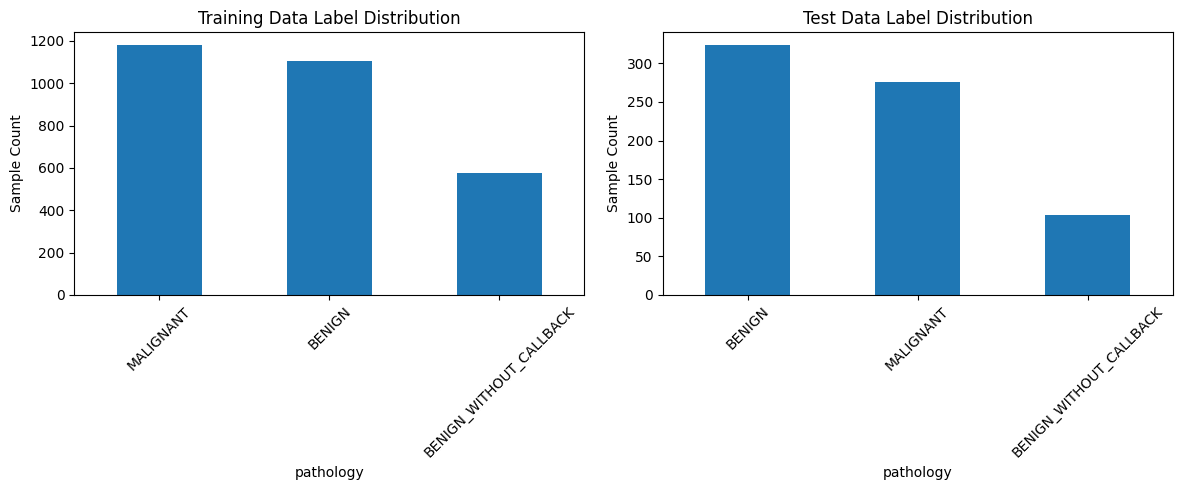

In [12]:
# 第3步：分析資料分佈
# 合併訓練資料
train_data = pd.concat([data['calc_train'], data['mass_train']], ignore_index=True)
test_data = pd.concat([data['calc_test'], data['mass_test']], ignore_index=True)

print("=== 資料集統計 ===")
print(f"訓練資料: {len(train_data)} 筆")
print(f"測試資料: {len(test_data)} 筆")
print(f"總資料: {len(train_data) + len(test_data)} 筆")

# 分析標籤分佈
print("\n=== 訓練資料標籤分佈 ===")
train_pathology = train_data['pathology'].value_counts()
print(train_pathology)

print("\n=== 測試資料標籤分佈 ===")
test_pathology = test_data['pathology'].value_counts()
print(test_pathology)

# 視覺化標籤分佈
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

train_pathology.plot(kind='bar', ax=ax1, title='Training Data Label Distribution')
ax1.set_ylabel('Sample Count')
ax1.tick_params(axis='x', rotation=45)

test_pathology.plot(kind='bar', ax=ax2, title='Test Data Label Distribution')
ax2.set_ylabel('Sample Count')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


In [13]:
# 第4步：建立正確的檔案路徑對應
def create_dicom_to_jpeg_mapping():
    """建立DICOM ID到JPEG檔案的對應關係"""
    jpeg_base = Path('archive/jpeg')
    mapping = {}
    
    print("正在建立DICOM到JPEG的對應關係...")
    
    for dicom_dir in jpeg_base.iterdir():
        if dicom_dir.is_dir():
            dicom_id = dicom_dir.name
            jpeg_files = list(dicom_dir.glob('*.jpg'))
            
            if jpeg_files:
                # 根據檔案名稱中的數字排序
                jpeg_files.sort(key=lambda x: int(x.stem.split('-')[1]))
                mapping[dicom_id] = [str(f) for f in jpeg_files]
    
    print(f"找到 {len(mapping)} 個DICOM目錄，包含 {sum(len(files) for files in mapping.values())} 個JPEG檔案")
    return mapping

def analyze_csv_dicom_mapping(train_data, test_data, dicom_to_jpeg):
    """分析CSV中的DICOM路徑與實際JPEG檔案的對應"""
    
    print("\n=== 分析CSV與JPEG檔案對應 ===")
    
    # 檢查幾個範例
    for i, row in train_data.head(3).iterrows():
        print(f"\n範例 {i+1}:")
        print(f"Patient ID: {row['patient_id']}")
        print(f"Image file path: {row['image file path']}")
        print(f"ROI mask file path: {row['ROI mask file path']}")
        
        # 從路徑提取DICOM ID
        import re
        pattern = r'1\.3\.6\.1\.4\.1\.9590\.100\.1\.2\.(\d+)'
        matches = re.findall(pattern, row['image file path'])
        if matches:
            extracted_id = f"1.3.6.1.4.1.9590.100.1.2.{matches[-1]}"
            print(f"提取的DICOM ID: {extracted_id}")
            
            # 檢查是否在JPEG映射中
            if extracted_id in dicom_to_jpeg:
                print(f"✓ 找到對應JPEG檔案: {len(dicom_to_jpeg[extracted_id])} 個")
                print(f"  檔案: {dicom_to_jpeg[extracted_id]}")
            else:
                print(f"✗ 未找到對應JPEG檔案")
        
        # 檢查mask路徑
        mask_matches = re.findall(pattern, row['ROI mask file path'])
        if mask_matches:
            mask_id = f"1.3.6.1.4.1.9590.100.1.2.{mask_matches[-1]}"
            print(f"Mask DICOM ID: {mask_id}")

# 建立對應關係
dicom_to_jpeg = create_dicom_to_jpeg_mapping()

# 分析對應關係
analyze_csv_dicom_mapping(train_data, test_data, dicom_to_jpeg)

# 顯示一些範例
print("\n=== JPEG檔案對應範例 ===")
for i, (dicom_id, files) in enumerate(dicom_to_jpeg.items()):
    if i < 3:  # 只顯示前3個
        print(f"DICOM ID: {dicom_id}")
        print(f"JPEG檔案數量: {len(files)}")
        if files:
            print(f"第一個檔案: {files[0]}")
        print()


正在建立DICOM到JPEG的對應關係...
找到 6774 個DICOM目錄，包含 10237 個JPEG檔案

=== 分析CSV與JPEG檔案對應 ===

範例 1:
Patient ID: P_00005
Image file path: Calc-Training_P_00005_RIGHT_CC/1.3.6.1.4.1.9590.100.1.2.408909860712120272633130274602115723157/1.3.6.1.4.1.9590.100.1.2.47414316010368386519740343172775938548/000000.dcm
ROI mask file path: Calc-Training_P_00005_RIGHT_CC_1/1.3.6.1.4.1.9590.100.1.2.328778919012412769218080124214088709081/1.3.6.1.4.1.9590.100.1.2.393344010211719049419601138200355094682/000000.dcm
提取的DICOM ID: 1.3.6.1.4.1.9590.100.1.2.47414316010368386519740343172775938548
✓ 找到對應JPEG檔案: 1 個
  檔案: ['archive\\jpeg\\1.3.6.1.4.1.9590.100.1.2.47414316010368386519740343172775938548\\1-188.jpg']
Mask DICOM ID: 1.3.6.1.4.1.9590.100.1.2.393344010211719049419601138200355094682

範例 2:
Patient ID: P_00005
Image file path: Calc-Training_P_00005_RIGHT_MLO/1.3.6.1.4.1.9590.100.1.2.427517897311902339923511678883689433338/1.3.6.1.4.1.9590.100.1.2.250596608311207922527805669693579696727/000000.dcm
ROI mask file path

In [14]:
# 第5步：使用CSV中的mask資訊正確過濾檔案
def extract_dicom_id_from_path(file_path):
    """從檔案路徑中提取DICOM ID"""
    # CSV中的路徑格式類似: "image file path"欄位包含DICOM路徑
    # 我們需要從DICOM路徑提取出對應的ID
    import re
    # 尋找路徑中的長數字ID (DICOM ID)
    pattern = r'1\.3\.6\.1\.4\.1\.9590\.100\.1\.2\.(\d+)'
    matches = re.findall(pattern, file_path)
    if matches:
        return f"1.3.6.1.4.1.9590.100.1.2.{matches[-1]}"  # 取最後一個作為主要ID
    return None

def create_mask_set_from_csv(train_data, test_data):
    """從CSV的ROI mask file path欄位建立mask檔案集合"""
    mask_paths = set()
    
    # 從訓練資料收集mask路徑
    for idx, row in train_data.iterrows():
        mask_path = row.get('ROI mask file path', '')
        if mask_path and mask_path.strip():
            dicom_id = extract_dicom_id_from_path(mask_path)
            if dicom_id:
                mask_paths.add(dicom_id)
    
    # 從測試資料收集mask路徑  
    for idx, row in test_data.iterrows():
        mask_path = row.get('ROI mask file path', '')
        if mask_path and mask_path.strip():
            dicom_id = extract_dicom_id_from_path(mask_path)
            if dicom_id:
                mask_paths.add(dicom_id)
    
    print(f"從CSV識別出 {len(mask_paths)} 個mask DICOM ID")
    return mask_paths

def is_valid_image(image_path, min_size=(50, 50)):
    """檢查影像是否有效（基本品質檢查）"""
    try:
        with Image.open(image_path) as img:
            # 檢查影像大小
            if img.size[0] < min_size[0] or img.size[1] < min_size[1]:
                return False
            return True
    except:
        return False

def filter_and_validate_images(train_data, test_data, dicom_to_jpeg):
    """使用CSV資訊正確過濾影像檔案"""
    
    # 建立mask DICOM ID集合
    mask_dicom_ids = create_mask_set_from_csv(train_data, test_data)
    
    valid_train = []
    valid_test = []
    filtered_mask_count = 0
    
    # 處理訓練資料
    print("正在處理訓練資料...")
    for idx, row in train_data.iterrows():
        # 從image file path提取DICOM ID
        image_path = row.get('image file path', '')
        main_dicom_id = extract_dicom_id_from_path(image_path)
        
        if main_dicom_id and main_dicom_id in dicom_to_jpeg:
            jpeg_files = dicom_to_jpeg[main_dicom_id]
            
            # 檢查每個JPEG檔案
            for jpeg_file in jpeg_files:
                # 從JPEG檔案路徑提取DICOM ID來檢查是否為mask
                jpeg_dicom_id = None
                for dicom_id in dicom_to_jpeg:
                    if jpeg_file in dicom_to_jpeg[dicom_id]:
                        jpeg_dicom_id = dicom_id
                        break
                
                # 如果這個DICOM ID在mask集合中，跳過
                if jpeg_dicom_id in mask_dicom_ids:
                    filtered_mask_count += 1
                    continue
                
                # 檢查影像品質
                if is_valid_image(jpeg_file):
                    valid_train.append({
                        'image_path': jpeg_file,
                        'label': row['pathology'],
                        'patient_id': row['patient_id'],
                        'abnormality_type': row.get('abnormality type', 'unknown'),
                        'dicom_id': jpeg_dicom_id
                    })
    
    # 處理測試資料
    print("正在處理測試資料...")
    for idx, row in test_data.iterrows():
        # 從image file path提取DICOM ID
        image_path = row.get('image file path', '')
        main_dicom_id = extract_dicom_id_from_path(image_path)
        
        if main_dicom_id and main_dicom_id in dicom_to_jpeg:
            jpeg_files = dicom_to_jpeg[main_dicom_id]
            
            # 檢查每個JPEG檔案
            for jpeg_file in jpeg_files:
                # 從JPEG檔案路徑提取DICOM ID來檢查是否為mask
                jpeg_dicom_id = None
                for dicom_id in dicom_to_jpeg:
                    if jpeg_file in dicom_to_jpeg[dicom_id]:
                        jpeg_dicom_id = dicom_id
                        break
                
                # 如果這個DICOM ID在mask集合中，跳過
                if jpeg_dicom_id in mask_dicom_ids:
                    filtered_mask_count += 1
                    continue
                
                # 檢查影像品質
                if is_valid_image(jpeg_file):
                    valid_test.append({
                        'image_path': jpeg_file,
                        'label': row['pathology'],
                        'patient_id': row['patient_id'],
                        'abnormality_type': row.get('abnormality type', 'unknown'),
                        'dicom_id': jpeg_dicom_id
                    })
    
    print(f"✓ 根據CSV資訊過濾了 {filtered_mask_count} 個mask檔案")
    return pd.DataFrame(valid_train), pd.DataFrame(valid_test)

# 執行影像過濾
valid_train_df, valid_test_df = filter_and_validate_images(train_data, test_data, dicom_to_jpeg)

print(f"\n=== 有效影像統計 ===")
print(f"有效訓練影像: {len(valid_train_df)}")
print(f"有效測試影像: {len(valid_test_df)}")

print("\n=== 原始標籤分佈 ===")
print("訓練集:")
print(valid_train_df['label'].value_counts())
print("\n測試集:")
print(valid_test_df['label'].value_counts())

# 轉換為二分類：將BENIGN_WITHOUT_CALLBACK合併到BENIGN
def convert_to_binary_classification(df):
    """將三分類轉換為二分類"""
    df = df.copy()
    # 將BENIGN_WITHOUT_CALLBACK重新標記為BENIGN
    df.loc[df['label'] == 'BENIGN_WITHOUT_CALLBACK', 'label'] = 'BENIGN'
    return df

# 應用二分類轉換
valid_train_df = convert_to_binary_classification(valid_train_df)
valid_test_df = convert_to_binary_classification(valid_test_df)

print("\n=== 轉換為二分類後的標籤分佈 ===")
print("訓練集:")
print(valid_train_df['label'].value_counts())
print("\n測試集:")
print(valid_test_df['label'].value_counts())

# 確認只有兩個類別
unique_labels = set(valid_train_df['label'].unique()) | set(valid_test_df['label'].unique())
print(f"\n✓ 確認為二分類問題，類別：{sorted(unique_labels)}")


從CSV識別出 3568 個mask DICOM ID
正在處理訓練資料...
正在處理測試資料...
✓ 根據CSV資訊過濾了 0 個mask檔案

=== 有效影像統計 ===
有效訓練影像: 2864
有效測試影像: 704

=== 原始標籤分佈 ===
訓練集:
label
MALIGNANT                  1181
BENIGN                     1105
BENIGN_WITHOUT_CALLBACK     578
Name: count, dtype: int64

測試集:
label
BENIGN                     324
MALIGNANT                  276
BENIGN_WITHOUT_CALLBACK    104
Name: count, dtype: int64

=== 轉換為二分類後的標籤分佈 ===
訓練集:
label
BENIGN       1683
MALIGNANT    1181
Name: count, dtype: int64

測試集:
label
BENIGN       428
MALIGNANT    276
Name: count, dtype: int64

✓ 確認為二分類問題，類別：['BENIGN', 'MALIGNANT']


✓ 資料增強管道創建完成
展示增強效果，使用影像: archive\jpeg\1.3.6.1.4.1.9590.100.1.2.47414316010368386519740343172775938548\1-188.jpg


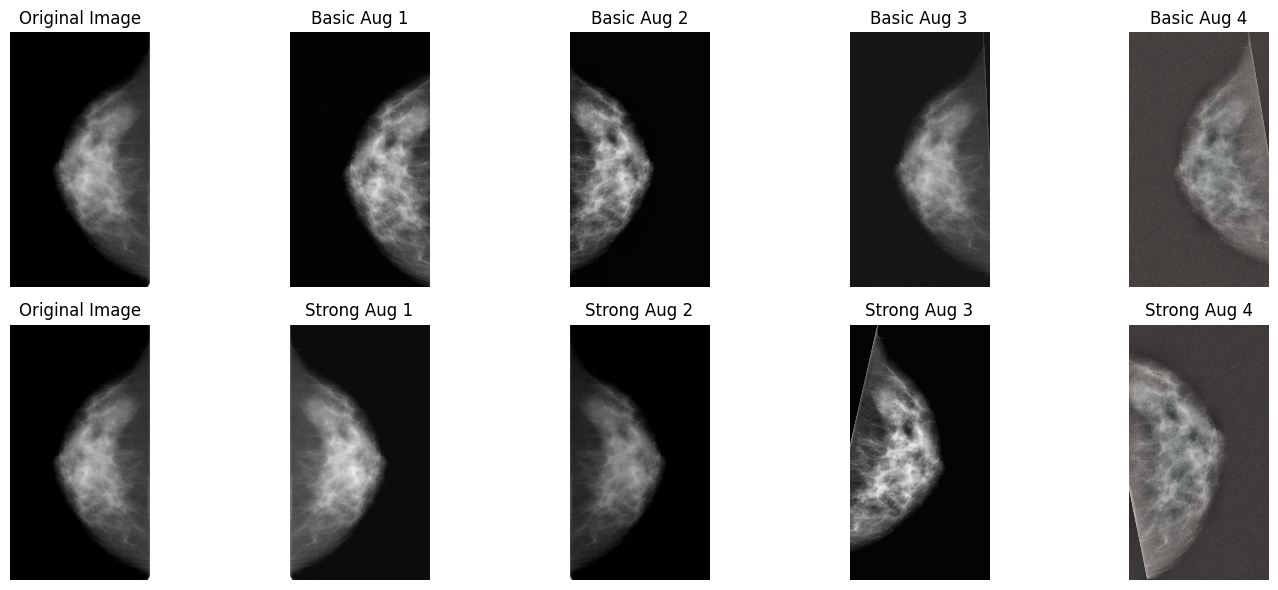

In [ ]:
# 第6步：資料增強設定
def create_augmentation_pipeline():
    """創建醫學影像專用的資料增強"""
    
    # 基礎增強（適用於所有影像）
    basic_augmentation = A.Compose([
        # 幾何變換
        A.HorizontalFlip(p=0.5),  # 水平翻轉
        A.Rotate(limit=10, p=0.3),  # 小角度旋轉
        A.ShiftScaleRotate(
            shift_limit=0.1,
            scale_limit=0.1, 
            rotate_limit=5,
            p=0.3
        ),
        
        # 影像品質增強
        A.RandomBrightnessContrast(
            brightness_limit=0.1,
            contrast_limit=0.1,
            p=0.3
        ),
        A.GaussNoise(var_limit=(10.0, 50.0), p=0.2),
        A.GaussianBlur(blur_limit=3, p=0.1),
        
        # 醫學影像特定增強
        A.CLAHE(clip_limit=2.0, tile_grid_size=(8, 8), p=0.3),  # 對比度限制自適應直方圖均衡
        A.Sharpen(alpha=(0.2, 0.5), lightness=(0.5, 1.0), p=0.2),  # 銳化
        
        # 正規化到YOLOv8期望的格式
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    
    # 強化增強（用於少數類別）
    strong_augmentation = A.Compose([
        A.HorizontalFlip(p=0.7),
        A.Rotate(limit=15, p=0.5),
        A.ShiftScaleRotate(
            shift_limit=0.15,
            scale_limit=0.15,
            rotate_limit=10,
            p=0.5
        ),
        A.RandomBrightnessContrast(
            brightness_limit=0.15,
            contrast_limit=0.15,
            p=0.5
        ),
        A.GaussNoise(var_limit=(10.0, 70.0), p=0.3),
        A.CLAHE(clip_limit=3.0, tile_grid_size=(8, 8), p=0.5),
        A.Sharpen(alpha=(0.2, 0.7), lightness=(0.5, 1.0), p=0.3),
        A.ElasticTransform(alpha=50, sigma=5, p=0.2),  # 彈性變形
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    
    return basic_augmentation, strong_augmentation

# 創建增強管道
basic_aug, strong_aug = create_augmentation_pipeline()
print("✓ 資料增強創建完成")

# 展示增強效果
def show_augmentation_examples(image_path, num_examples=4):
    """展示資料增強效果"""
    # 讀取原始影像
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    fig, axes = plt.subplots(2, num_examples + 1, figsize=(15, 6))
    
    # 原始影像
    axes[0, 0].imshow(image)
    axes[0, 0].set_title('Original Image')
    axes[0, 0].axis('off')
    
    axes[1, 0].imshow(image)
    axes[1, 0].set_title('Original Image')
    axes[1, 0].axis('off')
    
    
    for i in range(num_examples):
        augmented = basic_aug(image=image)['image']
        # 反正規化以便顯示
        augmented = augmented * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        augmented = np.clip(augmented, 0, 1)
        
        axes[0, i+1].imshow(augmented)
        axes[0, i+1].set_title(f'Basic Aug {i+1}')
        axes[0, i+1].axis('off')
    
   
    for i in range(num_examples):
        augmented = strong_aug(image=image)['image']
        # 反正規化以便顯示
        augmented = augmented * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        augmented = np.clip(augmented, 0, 1)
        
        axes[1, i+1].imshow(augmented)
        axes[1, i+1].set_title(f'Strong Aug {i+1}')
        axes[1, i+1].axis('off')
    
    plt.tight_layout()
    plt.show()

# 展示增強效果（如果有可用的影像）
if len(valid_train_df) > 0:
    sample_image = valid_train_df.iloc[0]['image_path']
    print(f"展示增強效果，使用影像: {sample_image}")
    show_augmentation_examples(sample_image)


原始訓練資料分佈:
label
BENIGN       1683
MALIGNANT    1181
Name: count, dtype: int64

平衡後訓練資料分佈:
label
BENIGN       1346
MALIGNANT    1181
Name: count, dtype: int64
需要強化增強的樣本數: 1181

=== 最終資料分割 ===
訓練資料: 2021 張影像
驗證資料: 506 張影像
測試資料: 704 張影像


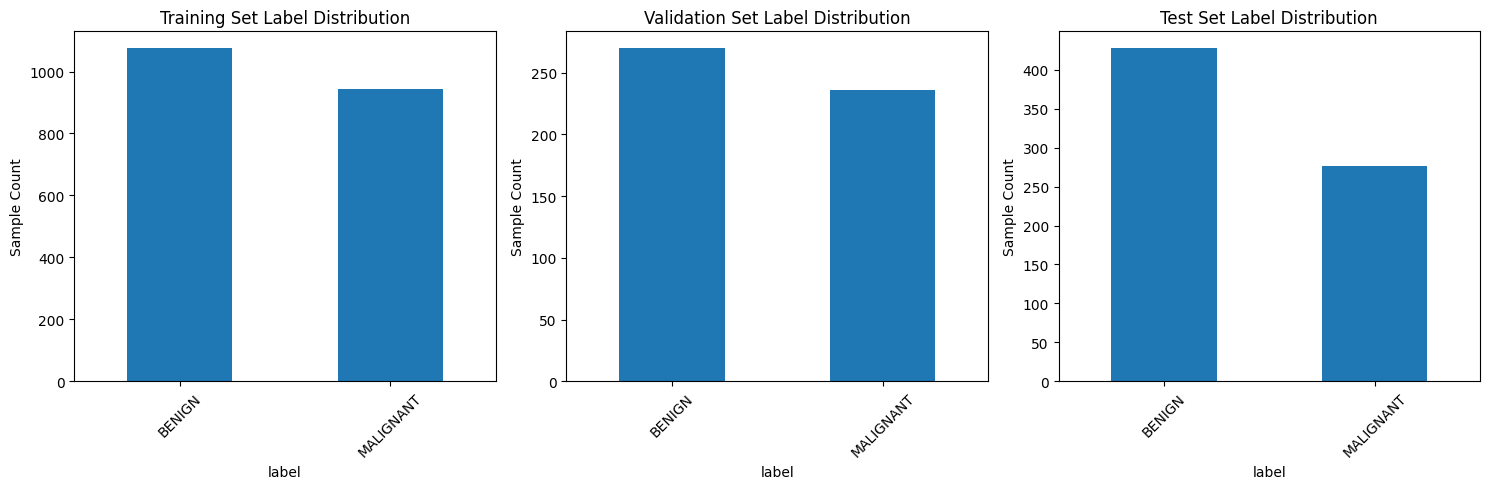

In [16]:
# 第7步：建立平衡資料集與資料分割
def create_balanced_dataset(train_df, test_df, balance_ratio=0.8):
    """創建平衡的資料集"""
    
    # 分析標籤分佈
    train_counts = train_df['label'].value_counts()
    print("原始訓練資料分佈:")
    print(train_counts)
    
    # 計算目標樣本數
    max_samples = train_counts.max()
    target_samples = int(max_samples * balance_ratio)
    
    balanced_train = []
    
    for label in train_counts.index:
        label_data = train_df[train_df['label'] == label]
        current_count = len(label_data)
        
        if current_count >= target_samples:
            # 如果樣本數足夠，隨機採樣
            sampled_data = label_data.sample(n=target_samples, random_state=42)
        else:
            # 如果樣本數不足，使用所有樣本並記錄需要增強
            sampled_data = label_data.copy()
            # 標記需要強化增強
            sampled_data = sampled_data.copy()
            sampled_data['needs_strong_aug'] = True
        
        balanced_train.append(sampled_data)
    
    balanced_train_df = pd.concat(balanced_train, ignore_index=True)
    
    # 確保沒有needs_strong_aug欄位的資料設為False
    if 'needs_strong_aug' not in balanced_train_df.columns:
        balanced_train_df['needs_strong_aug'] = False
    else:
        balanced_train_df['needs_strong_aug'] = balanced_train_df['needs_strong_aug'].fillna(False)
    
    print(f"\n平衡後訓練資料分佈:")
    print(balanced_train_df['label'].value_counts())
    print(f"需要強化增強的樣本數: {balanced_train_df['needs_strong_aug'].sum()}")
    
    return balanced_train_df, test_df

# 創建平衡資料集
balanced_train_df, final_test_df = create_balanced_dataset(valid_train_df, valid_test_df)

# 分割訓練和驗證資料
train_df, val_df = train_test_split(
    balanced_train_df, 
    test_size=0.2, 
    random_state=42, 
    stratify=balanced_train_df['label']
)

print(f"\n=== 最終資料分割 ===")
print(f"訓練資料: {len(train_df)} 張影像")
print(f"驗證資料: {len(val_df)} 張影像")
print(f"測試資料: {len(final_test_df)} 張影像")

# 顯示各集合的標籤分佈
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

train_df['label'].value_counts().plot(kind='bar', ax=axes[0], title='Training Set Label Distribution')
val_df['label'].value_counts().plot(kind='bar', ax=axes[1], title='Validation Set Label Distribution')
final_test_df['label'].value_counts().plot(kind='bar', ax=axes[2], title='Test Set Label Distribution')

for ax in axes:
    ax.tick_params(axis='x', rotation=45)
    ax.set_ylabel('Sample Count')

plt.tight_layout()
plt.show()


In [17]:
# 第8步：建立YOLOv8分類資料結構
def setup_yolo_classification_dataset(train_df, val_df, test_df, base_dir='yolo_cls_dataset'):
    """建立YOLOv8分類格式的資料集結構 (每個類別一個資料夾)"""
    
    # 獲取所有唯一標籤
    unique_labels = sorted(list(set(train_df['label'].unique()) | 
                               set(val_df['label'].unique()) | 
                               set(test_df['label'].unique())))
    
    print(f"類別標籤: {unique_labels}")
    
    # 為分類任務創建目錄結構: train/class_name/, val/class_name/, test/class_name/
    for split in ['train', 'val', 'test']:
        for label in unique_labels:
            class_dir = os.path.join(base_dir, split, label)
            os.makedirs(class_dir, exist_ok=True)
    
    def copy_and_augment_classification_images(df, split_name, apply_augmentation=True):
        """複製影像到對應的類別資料夾並應用增強"""
        copied_count = 0
        augmented_count = 0
        
        for idx, row in df.iterrows():
            src_path = row['image_path']
            label = row['label']
            needs_strong_aug = row.get('needs_strong_aug', False)
            
            # 目標類別資料夾
            class_dir = os.path.join(base_dir, split_name, label)
            
            try:
                # 讀取影像
                image = cv2.imread(src_path)
                if image is None:
                    continue
                    
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                
                # 原始影像檔案名稱
                original_name = f"{split_name}_{label}_{copied_count:06d}.jpg"
                dst_image_path = os.path.join(class_dir, original_name)
                
                # 儲存原始影像
                cv2.imwrite(dst_image_path, cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
                copied_count += 1
                
                # 如果是訓練資料且需要增強
                if apply_augmentation and split_name == 'train':
                    # 選擇增強方式
                    aug_pipeline = strong_aug if needs_strong_aug else basic_aug
                    
                    # 產生增強版本
                    num_augmentations = 3 if needs_strong_aug else 1
                    
                    for aug_idx in range(num_augmentations):
                        try:
                            # 應用增強
                            augmented = aug_pipeline(image=image)['image']
                            
                            # 反正規化
                            augmented = augmented * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
                            augmented = np.clip(augmented * 255, 0, 255).astype(np.uint8)
                            
                            # 儲存增強影像
                            aug_name = f"{split_name}_{label}_{copied_count:06d}_aug_{aug_idx}.jpg"
                            aug_image_path = os.path.join(class_dir, aug_name)
                            
                            cv2.imwrite(aug_image_path, cv2.cvtColor(augmented, cv2.COLOR_RGB2BGR))
                            augmented_count += 1
                        except Exception as e:
                            print(f"增強失敗 {src_path}, aug {aug_idx}: {e}")
                            continue
                        
            except Exception as e:
                print(f"處理檔案時發生錯誤 {src_path}: {e}")
                continue
        
        print(f"{split_name}: 複製了 {copied_count} 張原始影像，產生了 {augmented_count} 張增強影像")
        return copied_count, augmented_count
    
    # 處理各資料集
    print("正在建立YOLOv8分類資料集...")
    train_orig, train_aug = copy_and_augment_classification_images(train_df, 'train', True)
    val_orig, val_aug = copy_and_augment_classification_images(val_df, 'val', False)
    test_orig, test_aug = copy_and_augment_classification_images(test_df, 'test', False)
    
    # 建立簡單的配置檔案 (分類任務只需要指定根目錄)
    yaml_content = {
        'path': os.path.abspath(base_dir),
        'train': 'train',
        'val': 'val', 
        'test': 'test',
        'nc': len(unique_labels),
        'names': {i: name for i, name in enumerate(unique_labels)}
    }
    
    yaml_path = f'{base_dir}/data.yaml'
    with open(yaml_path, 'w', encoding='utf-8') as f:
        yaml.dump(yaml_content, f, default_flow_style=False, allow_unicode=True)
    
    print(f"\n✓ YOLOv8分類資料集建立完成")
    print(f"✓ 配置檔案已儲存: {yaml_path}")
    print(f"✓ 資料夾結構:")
    for split in ['train', 'val', 'test']:
        for label in unique_labels:
            class_dir = os.path.join(base_dir, split, label)
            if os.path.exists(class_dir):
                count = len([f for f in os.listdir(class_dir) if f.endswith('.jpg')])
                print(f"   {split}/{label}: {count} 張影像")
    
    # 創建標籤對應
    label_to_id = {name: i for i, name in enumerate(unique_labels)}
    
    return yaml_path, label_to_id

# 建立YOLOv8分類資料集
yaml_path, label_mapping = setup_yolo_classification_dataset(train_df, val_df, final_test_df)


類別標籤: ['BENIGN', 'MALIGNANT']
正在建立YOLOv8分類資料集...
train: 複製了 2021 張原始影像，產生了 3911 張增強影像
val: 複製了 506 張原始影像，產生了 0 張增強影像
test: 複製了 704 張原始影像，產生了 0 張增強影像

✓ YOLOv8分類資料集建立完成
✓ 配置檔案已儲存: yolo_cls_dataset/data.yaml
✓ 資料夾結構:
   train/BENIGN: 2152 張影像
   train/MALIGNANT: 3780 張影像
   val/BENIGN: 270 張影像
   val/MALIGNANT: 236 張影像
   test/BENIGN: 428 張影像
   test/MALIGNANT: 276 張影像


In [19]:
# 第9步：配置並訓練YOLOv8模型


# 開始訓練
print("正在訓練YOLOv8模型...")

# 直接使用資料集目錄進行訓練
trained_model = YOLO('yolov8s-cls.pt')
print("載入預訓練模型: yolov8s-cls.pt")

# 使用資料集目錄路徑
dataset_dir = os.path.dirname(yaml_path)  # 獲取 yolo_cls_dataset 目錄
print(f"使用資料集目錄: {dataset_dir}")

# 簡化的訓練參數
train_args = {
    'data': dataset_dir,  # 直接使用目錄路徑
    'epochs': 50,
    'imgsz': 640,
    'batch': 16,
    'lr0': 0.001,
    'device': '',
    'project': 'mammography_classification',
    'name': 'yolov8s_improved',
    'exist_ok': True,
    'amp': True,
    'plots': True,
    'val': True,
}

print("\n開始訓練YOLOv8分類模型...")
print(f"訓練參數: 50 epochs, 影像大小: 640, 批次大小: 16")

# 開始訓練
training_results = trained_model.train(**train_args)
print("\n✓ 訓練完成！")


正在訓練YOLOv8模型...
載入預訓練模型: yolov8s-cls.pt
使用資料集目錄: yolo_cls_dataset

開始訓練YOLOv8分類模型...
訓練參數: 50 epochs, 影像大小: 640, 批次大小: 16
Ultralytics 8.3.166  Python-3.10.16 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3060 Ti, 8192MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=yolo_cls_dataset, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s-cls.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov8s_improved, nbs=6

train: Scanning C:\Users\Kenny\Desktop\104\yolo_cls_dataset\train... 5932 images, 0 corrupt: 100%|██████████| 5932/5932 [00:06<00:00, 930.22it/s] 


train: New cache created: C:\Users\Kenny\Desktop\104\yolo_cls_dataset\train.cache
val: Fast image access  (ping: 0.10.0 ms, read: 150.824.3 MB/s, size: 1886.7 KB)


val: Scanning C:\Users\Kenny\Desktop\104\yolo_cls_dataset\val... 506 images, 0 corrupt: 100%|██████████| 506/506 [00:00<00:00, 572.92it/s]

val: New cache created: C:\Users\Kenny\Desktop\104\yolo_cls_dataset\val.cache


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 26 weight(decay=0.0), 27 weight(decay=0.0005), 27 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to mammography_classification\yolov8s_improved
Starting training for 50 epochs...

      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 16/16 [00:01<00:00,  9.50it/s]

                   all      0.621          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 16/16 [00:02<00:00,  6.23it/s]

                   all      0.543          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 16/16 [00:01<00:00, 10.46it/s]

                   all      0.632          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 16/16 [00:01<00:00, 10.92it/s]

                   all      0.543          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 16/16 [00:01<00:00, 10.23it/s]

                   all      0.591          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 16/16 [00:01<00:00,  9.93it/s]

                   all      0.619          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 16/16 [00:01<00:00, 10.10it/s]

                   all      0.567          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 16/16 [00:01<00:00, 11.77it/s]

                   all      0.658          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 16/16 [00:01<00:00,  9.97it/s]

                   all      0.634          1



      Epoch    GPU_mem       loss  Instances       Size


      10/50      3.21G     0.5523         12        640: 100%|██████████| 371/371 [05:40<00:00,  1.09it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 16/16 [00:01<00:00,  8.79it/s]

                   all      0.656          1



      Epoch    GPU_mem       loss  Instances       Size


      11/50      3.23G     0.5407         12        640: 100%|██████████| 371/371 [06:11<00:00,  1.00s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 16/16 [00:01<00:00,  9.73it/s]

                   all      0.597          1



      Epoch    GPU_mem       loss  Instances       Size


      12/50      3.24G     0.5331         12        640: 100%|██████████| 371/371 [06:06<00:00,  1.01it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 16/16 [00:01<00:00,  9.07it/s]

                   all      0.684          1



      Epoch    GPU_mem       loss  Instances       Size


      13/50      3.25G      0.528         12        640: 100%|██████████| 371/371 [06:00<00:00,  1.03it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 16/16 [00:01<00:00, 10.82it/s]


                   all      0.668          1

      Epoch    GPU_mem       loss  Instances       Size


      14/50      3.26G     0.5276         12        640: 100%|██████████| 371/371 [05:54<00:00,  1.05it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 16/16 [00:01<00:00, 11.03it/s]

                   all      0.656          1



      Epoch    GPU_mem       loss  Instances       Size


      15/50      3.27G      0.524         12        640: 100%|██████████| 371/371 [06:01<00:00,  1.03it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 16/16 [00:01<00:00, 10.38it/s]

                   all       0.66          1



      Epoch    GPU_mem       loss  Instances       Size


      16/50      3.29G     0.5256         12        640: 100%|██████████| 371/371 [06:24<00:00,  1.04s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 16/16 [00:01<00:00,  9.13it/s]

                   all      0.646          1



      Epoch    GPU_mem       loss  Instances       Size


      17/50       3.3G     0.5237         12        640: 100%|██████████| 371/371 [06:07<00:00,  1.01it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 16/16 [00:01<00:00, 10.16it/s]


                   all       0.68          1

      Epoch    GPU_mem       loss  Instances       Size


      18/50      3.31G      0.518         12        640: 100%|██████████| 371/371 [06:03<00:00,  1.02it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 16/16 [00:01<00:00, 10.39it/s]

                   all      0.668          1



      Epoch    GPU_mem       loss  Instances       Size


      19/50      3.32G     0.5127         12        640: 100%|██████████| 371/371 [06:03<00:00,  1.02it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 16/16 [00:01<00:00,  9.34it/s]


                   all      0.642          1

      Epoch    GPU_mem       loss  Instances       Size


      20/50      3.33G     0.5093         12        640: 100%|██████████| 371/371 [06:16<00:00,  1.01s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 16/16 [00:01<00:00,  8.78it/s]

                   all      0.638          1



      Epoch    GPU_mem       loss  Instances       Size


      21/50      3.34G     0.5062         12        640: 100%|██████████| 371/371 [06:10<00:00,  1.00it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 16/16 [00:01<00:00,  9.83it/s]


                   all      0.662          1

      Epoch    GPU_mem       loss  Instances       Size


      22/50      3.35G     0.5022         12        640: 100%|██████████| 371/371 [05:53<00:00,  1.05it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 16/16 [00:01<00:00, 10.83it/s]

                   all      0.613          1



      Epoch    GPU_mem       loss  Instances       Size


      23/50      3.37G     0.4993         12        640: 100%|██████████| 371/371 [05:39<00:00,  1.09it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 16/16 [00:01<00:00, 10.20it/s]

                   all      0.674          1



      Epoch    GPU_mem       loss  Instances       Size


      24/50      3.38G     0.4933         12        640: 100%|██████████| 371/371 [06:14<00:00,  1.01s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 16/16 [00:01<00:00,  8.89it/s]

                   all      0.656          1



      Epoch    GPU_mem       loss  Instances       Size


      25/50      3.39G     0.4863         12        640: 100%|██████████| 371/371 [05:03<00:00,  1.22it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 16/16 [00:01<00:00, 11.27it/s]

                   all      0.668          1



      Epoch    GPU_mem       loss  Instances       Size


      26/50       3.4G     0.4816         12        640: 100%|██████████| 371/371 [04:45<00:00,  1.30it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 16/16 [00:01<00:00,  9.71it/s]

                   all      0.646          1



      Epoch    GPU_mem       loss  Instances       Size


      27/50      3.41G     0.4827         12        640: 100%|██████████| 371/371 [04:46<00:00,  1.30it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 16/16 [00:01<00:00,  9.50it/s]

                   all      0.666          1



      Epoch    GPU_mem       loss  Instances       Size


      28/50      3.43G     0.4867         12        640: 100%|██████████| 371/371 [04:44<00:00,  1.31it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 16/16 [00:01<00:00, 11.02it/s]

                   all      0.688          1



      Epoch    GPU_mem       loss  Instances       Size


      29/50      3.44G      0.478         12        640: 100%|██████████| 371/371 [04:52<00:00,  1.27it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 16/16 [00:01<00:00, 11.86it/s]

                   all      0.648          1



      Epoch    GPU_mem       loss  Instances       Size


      30/50      3.45G     0.4736         12        640: 100%|██████████| 371/371 [04:38<00:00,  1.33it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 16/16 [00:01<00:00, 11.24it/s]

                   all      0.678          1



      Epoch    GPU_mem       loss  Instances       Size


      31/50      3.46G     0.4636         12        640: 100%|██████████| 371/371 [04:52<00:00,  1.27it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 16/16 [00:01<00:00, 13.24it/s]

                   all      0.652          1



      Epoch    GPU_mem       loss  Instances       Size


      32/50      3.47G     0.4601         12        640: 100%|██████████| 371/371 [04:45<00:00,  1.30it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 16/16 [00:01<00:00, 13.13it/s]

                   all      0.686          1



      Epoch    GPU_mem       loss  Instances       Size


      33/50      3.48G     0.4565         12        640: 100%|██████████| 371/371 [05:06<00:00,  1.21it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 16/16 [00:01<00:00, 13.48it/s]

                   all      0.676          1



      Epoch    GPU_mem       loss  Instances       Size


      34/50      3.49G     0.4443         12        640: 100%|██████████| 371/371 [04:56<00:00,  1.25it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 16/16 [00:01<00:00, 10.72it/s]

                   all      0.682          1



      Epoch    GPU_mem       loss  Instances       Size


      35/50      3.51G     0.4381         12        640: 100%|██████████| 371/371 [04:57<00:00,  1.25it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 16/16 [00:01<00:00, 10.85it/s]

                   all      0.666          1



      Epoch    GPU_mem       loss  Instances       Size


      36/50      3.52G     0.4292         12        640: 100%|██████████| 371/371 [04:57<00:00,  1.25it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 16/16 [00:01<00:00, 10.55it/s]

                   all      0.708          1



      Epoch    GPU_mem       loss  Instances       Size


      37/50      3.53G     0.4194         12        640: 100%|██████████| 371/371 [05:00<00:00,  1.24it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 16/16 [00:01<00:00, 10.44it/s]

                   all      0.684          1



      Epoch    GPU_mem       loss  Instances       Size


      38/50      3.54G     0.4293         12        640: 100%|██████████| 371/371 [04:56<00:00,  1.25it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 16/16 [00:01<00:00, 10.86it/s]

                   all      0.704          1



      Epoch    GPU_mem       loss  Instances       Size


      39/50      3.55G     0.4199         12        640: 100%|██████████| 371/371 [05:05<00:00,  1.22it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 16/16 [00:01<00:00, 11.20it/s]

                   all        0.7          1



      Epoch    GPU_mem       loss  Instances       Size


      40/50      3.56G      0.404         12        640: 100%|██████████| 371/371 [05:01<00:00,  1.23it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 16/16 [00:01<00:00,  9.83it/s]

                   all      0.717          1



      Epoch    GPU_mem       loss  Instances       Size


      41/50      3.58G      0.398         12        640: 100%|██████████| 371/371 [04:46<00:00,  1.29it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 16/16 [00:01<00:00, 11.12it/s]

                   all      0.704          1



      Epoch    GPU_mem       loss  Instances       Size


      42/50      3.59G     0.3942         12        640: 100%|██████████| 371/371 [04:49<00:00,  1.28it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 16/16 [00:01<00:00, 11.71it/s]

                   all      0.723          1



      Epoch    GPU_mem       loss  Instances       Size


      43/50       3.6G     0.3784         12        640: 100%|██████████| 371/371 [04:48<00:00,  1.28it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 16/16 [00:01<00:00, 11.59it/s]

                   all      0.706          1



      Epoch    GPU_mem       loss  Instances       Size


      44/50      3.61G     0.3658         12        640: 100%|██████████| 371/371 [05:02<00:00,  1.23it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 16/16 [00:01<00:00, 11.46it/s]

                   all      0.713          1



      Epoch    GPU_mem       loss  Instances       Size


      45/50      3.62G     0.3616         12        640: 100%|██████████| 371/371 [05:08<00:00,  1.20it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 16/16 [00:01<00:00,  9.46it/s]

                   all      0.727          1



      Epoch    GPU_mem       loss  Instances       Size


      46/50      3.63G     0.3632         12        640: 100%|██████████| 371/371 [05:14<00:00,  1.18it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 16/16 [00:01<00:00,  9.51it/s]

                   all      0.737          1



      Epoch    GPU_mem       loss  Instances       Size


      47/50      3.65G     0.3513         12        640: 100%|██████████| 371/371 [05:07<00:00,  1.21it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 16/16 [00:01<00:00,  9.56it/s]

                   all      0.706          1



      Epoch    GPU_mem       loss  Instances       Size


      48/50      3.66G     0.3465         12        640: 100%|██████████| 371/371 [05:14<00:00,  1.18it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 16/16 [00:01<00:00, 10.31it/s]

                   all      0.709          1



      Epoch    GPU_mem       loss  Instances       Size


      49/50      3.67G     0.3331         12        640: 100%|██████████| 371/371 [05:08<00:00,  1.20it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 16/16 [00:01<00:00,  9.67it/s]


                   all      0.713          1

      Epoch    GPU_mem       loss  Instances       Size


      50/50      3.68G     0.3354         12        640: 100%|██████████| 371/371 [05:07<00:00,  1.21it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 16/16 [00:01<00:00, 10.57it/s]


                   all      0.709          1

50 epochs completed in 4.459 hours.
Optimizer stripped from mammography_classification\yolov8s_improved\weights\last.pt, 10.3MB
Optimizer stripped from mammography_classification\yolov8s_improved\weights\best.pt, 10.3MB

Validating mammography_classification\yolov8s_improved\weights\best.pt...
Ultralytics 8.3.166  Python-3.10.16 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3060 Ti, 8192MiB)
YOLOv8s-cls summary (fused): 30 layers, 5,077,762 parameters, 0 gradients, 12.4 GFLOPs
train: C:\Users\Kenny\Desktop\104\yolo_cls_dataset\train... found 5932 images in 2 classes  
val: C:\Users\Kenny\Desktop\104\yolo_cls_dataset\val... found 506 images in 2 classes  
test: C:\Users\Kenny\Desktop\104\yolo_cls_dataset\test... found 704 images in 2 classes  


               classes   top1_acc   top5_acc: 100%|██████████| 16/16 [00:21<00:00,  1.35s/it]


                   all      0.737          1
Speed: 1.3ms preprocess, 2.2ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to mammography_classification\yolov8s_improved

✓ 訓練完成！


載入最佳模型: mammography_classification/yolov8s_improved/weights/best.pt
✓ 成功載入最佳模型
Ultralytics 8.3.166  Python-3.10.16 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3060 Ti, 8192MiB)
YOLOv8s-cls summary (fused): 30 layers, 5,077,762 parameters, 0 gradients, 12.4 GFLOPs
train: C:\Users\Kenny\Desktop\104\yolo_cls_dataset\train... found 5932 images in 2 classes  
val: C:\Users\Kenny\Desktop\104\yolo_cls_dataset\val... found 506 images in 2 classes  
test: C:\Users\Kenny\Desktop\104\yolo_cls_dataset\test... found 704 images in 2 classes  
val: Fast image access  (ping: 0.10.0 ms, read: 1283.9141.5 MB/s, size: 1886.7 KB)


val: Scanning C:\Users\Kenny\Desktop\104\yolo_cls_dataset\val... 506 images, 0 corrupt: 100%|██████████| 506/506 [00:00<?, ?it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 32/32 [00:24<00:00,  1.32it/s]


                   all      0.735          1
Speed: 1.0ms preprocess, 4.4ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs\classify\val
Ultralytics 8.3.166  Python-3.10.16 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3060 Ti, 8192MiB)
train: C:\Users\Kenny\Desktop\104\yolo_cls_dataset\train... found 5932 images in 2 classes  
val: C:\Users\Kenny\Desktop\104\yolo_cls_dataset\val... found 506 images in 2 classes  
test: C:\Users\Kenny\Desktop\104\yolo_cls_dataset\test... found 704 images in 2 classes  
test: Fast image access  (ping: 0.10.0 ms, read: 151.746.2 MB/s, size: 1383.1 KB)


test: Scanning C:\Users\Kenny\Desktop\104\yolo_cls_dataset\test... 704 images, 0 corrupt: 100%|██████████| 704/704 [00:00<00:00, 766.23it/s]

test: New cache created: C:\Users\Kenny\Desktop\104\yolo_cls_dataset\test.cache



               classes   top1_acc   top5_acc: 100%|██████████| 44/44 [00:33<00:00,  1.31it/s]


                   all      0.693          1
Speed: 0.8ms preprocess, 3.8ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs\classify\val2

=== YOLO驗證集結果 ===
Top-1 Accuracy: 0.7352
Top-5 Accuracy: 1.0000

=== YOLO測試集結果 ===
Top-1 Accuracy: 0.6932
Top-5 Accuracy: 1.0000

開始醫學影像專用評估...
正在進行醫學影像專用評估...
正在對測試集進行預測...
成功預測 704 個樣本

醫學影像分類評估報告

📊 整體性能指標:
   準確率 (Accuracy):     0.7003
   加權精確率 (Precision): 0.6969
   加權召回率 (Recall):   0.7003
   加權F1分數 (F1-Score): 0.6979
   AUC-ROC:              0.7596

🏥 醫學診斷指標 (以MALIGNANT為陽性):
   敏感性 (Sensitivity):  0.5797 - 正確識別惡性的能力
   特異性 (Specificity):  0.7780 - 正確識別良性的能力
   陽性預測值 (PPV):      0.6275 - 預測為惡性時的準確性
   陰性預測值 (NPV):      0.7416 - 預測為良性時的準確性

📋 各類別詳細指標:
   BENIGN:
     精確率: 0.7416
     召回率: 0.7780
     F1分數: 0.7594
   MALIGNANT:
     精確率: 0.6275
     召回率: 0.5797
     F1分數: 0.6026


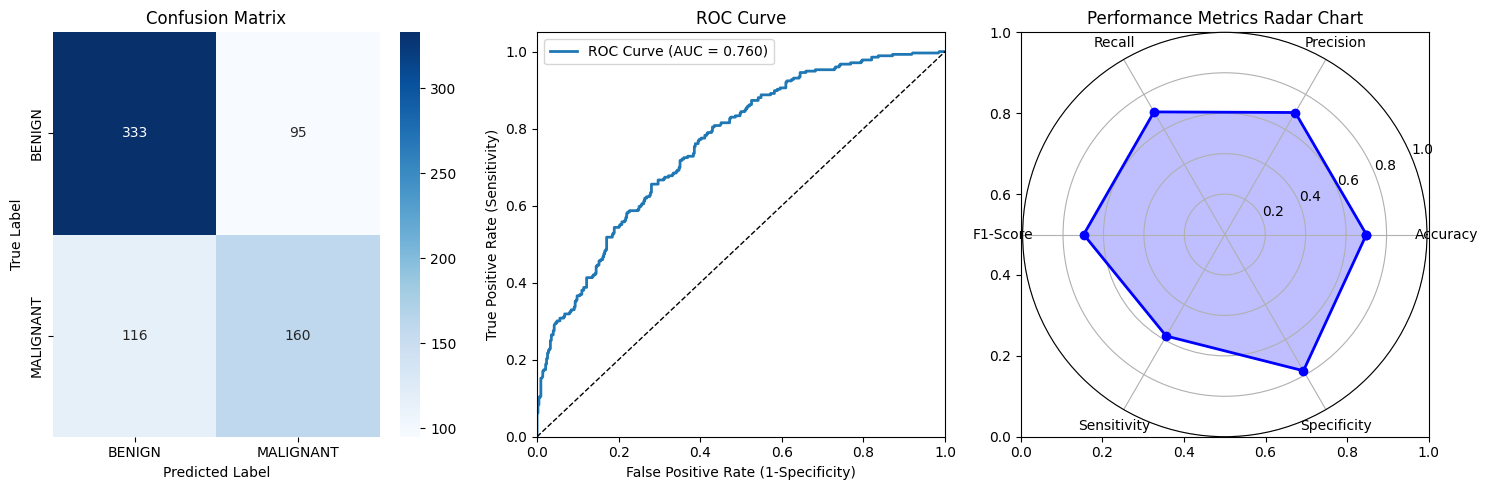


展示測試樣本預測結果:


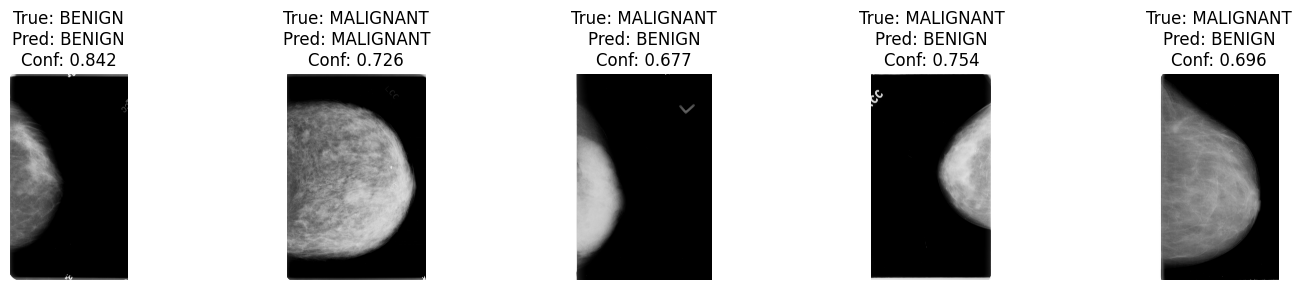

In [ ]:
# 第10步：模型驗證與評估
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    confusion_matrix, classification_report, roc_auc_score, roc_curve
)
from sklearn.preprocessing import LabelEncoder
import seaborn as sns

def comprehensive_medical_evaluation(model, test_df, label_mapping):
    """使用醫學影像常用指標進行全面評估"""
    
    print("正在進行醫學影像專用評估...")
    
    # 準備真實標籤和預測結果
    y_true = []
    y_pred = []
    y_prob = []
    
  
    le = LabelEncoder()
    le.fit(['BENIGN', 'MALIGNANT'])
    
    print("正在對測試集進行預測...")
    for idx, row in test_df.iterrows():
        image_path = row['image_path']
        true_label = row['label']
        
        # 進行預測
        try:
            results = model.predict(image_path, verbose=False)
            
            if results and len(results) > 0:
                result = results[0]
                if hasattr(result, 'probs') and result.probs is not None:
                    # 獲取預測概率
                    probs = result.probs.data.cpu().numpy()
                    predicted_idx = result.probs.top1
                    predicted_label = result.names[predicted_idx]
                    
                    y_true.append(le.transform([true_label])[0])
                    y_pred.append(le.transform([predicted_label])[0])
                    
                    # 對於二分類，取MALIGNANT的概率
                    if len(probs) == 2:
                        malignant_prob = probs[le.transform(['MALIGNANT'])[0]]
                        y_prob.append(malignant_prob)
                    else:
                        y_prob.append(max(probs))
                        
        except Exception as e:
            print(f"預測失敗: {image_path}, 錯誤: {e}")
            continue
    
    # 轉換為numpy數組
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_prob = np.array(y_prob)
    
    print(f"成功預測 {len(y_true)} 個樣本")
    
    # 計算醫學影像評估指標
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    
    # 二分類特定指標
    precision_per_class = precision_score(y_true, y_pred, average=None)
    recall_per_class = recall_score(y_true, y_pred, average=None)
    f1_per_class = f1_score(y_true, y_pred, average=None)
    
    # 敏感性和特異性 (以MALIGNANT為正類)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0  # 敏感性 (召回率)
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0  # 特異性
    
    # PPV和NPV
    ppv = tp / (tp + fp) if (tp + fp) > 0 else 0  # 陽性預測值 (精確率)
    npv = tn / (tn + fn) if (tn + fn) > 0 else 0  # 陰性預測值
    
    # AUC-ROC
    try:
        auc = roc_auc_score(y_true, y_prob)
    except:
        auc = 0.0
    
    # 結果
    print("\n" + "="*60)
    print("醫學影像分類評估報告")
    print("="*60)
    
    print(f"\n📊 整體性能指標:")
    print(f"   準確率 (Accuracy):     {accuracy:.4f}")
    print(f"   加權精確率 (Precision): {precision:.4f}")
    print(f"   加權召回率 (Recall):   {recall:.4f}")
    print(f"   加權F1分數 (F1-Score): {f1:.4f}")
    print(f"   AUC-ROC:              {auc:.4f}")
    
    print(f"\n🏥 醫學診斷指標 (以MALIGNANT為陽性):")
    print(f"   敏感性 (Sensitivity):  {sensitivity:.4f} - 正確識別惡性的能力")
    print(f"   特異性 (Specificity):  {specificity:.4f} - 正確識別良性的能力") 
    print(f"   陽性預測值 (PPV):      {ppv:.4f} - 預測為惡性時的準確性")
    print(f"   陰性預測值 (NPV):      {npv:.4f} - 預測為良性時的準確性")
    
    print(f"\n📋 各類別詳細指標:")
    class_names = ['BENIGN', 'MALIGNANT']
    for i, class_name in enumerate(class_names):
        print(f"   {class_name}:")
        print(f"     精確率: {precision_per_class[i]:.4f}")
        print(f"     召回率: {recall_per_class[i]:.4f}")
        print(f"     F1分數: {f1_per_class[i]:.4f}")
    
    # 混淆矩陣視覺化
    plt.figure(figsize=(15, 5))
    
    # 混淆矩陣
    plt.subplot(1, 3, 1)
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    
    # ROC曲線
    plt.subplot(1, 3, 2)
    if len(np.unique(y_true)) > 1:
        fpr, tpr, _ = roc_curve(y_true, y_prob)
        plt.plot(fpr, tpr, linewidth=2, label=f'ROC Curve (AUC = {auc:.3f})')
        plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate (1-Specificity)')
        plt.ylabel('True Positive Rate (Sensitivity)')
        plt.title('ROC Curve')
        plt.legend()
    
    # 性能指標雷達圖
    plt.subplot(1, 3, 3)
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'Sensitivity', 'Specificity']
    values = [accuracy, precision, recall, f1, sensitivity, specificity]
    
    angles = np.linspace(0, 2 * np.pi, len(metrics), endpoint=False)
    values += values[:1]  # 完成圓圈
    angles = np.concatenate((angles, [angles[0]]))
    
    ax = plt.subplot(1, 3, 3, projection='polar')
    ax.plot(angles, values, 'o-', linewidth=2, color='blue')
    ax.fill(angles, values, alpha=0.25, color='blue')
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(metrics)
    ax.set_ylim(0, 1)
    ax.set_title('Performance Metrics Radar Chart')
    
    plt.tight_layout()
    plt.show()
    
    # 返回評估結果
    evaluation_results = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'sensitivity': sensitivity,
        'specificity': specificity,
        'ppv': ppv,
        'npv': npv,
        'auc_roc': auc,
        'confusion_matrix': cm,
        'classification_report': classification_report(y_true, y_pred, target_names=class_names)
    }
    
    return evaluation_results

def predict_samples(model, test_df, num_samples=5):
    """對測試樣本進行預測並展示結果"""
    
    # 隨機選擇一些測試樣本
    sample_df = test_df.sample(n=min(num_samples, len(test_df)), random_state=42)
    
    fig, axes = plt.subplots(1, len(sample_df), figsize=(15, 3))
    if len(sample_df) == 1:
        axes = [axes]
    
    for idx, (_, row) in enumerate(sample_df.iterrows()):
        # 讀取影像
        image_path = row['image_path']
        true_label = row['label']
        
        # 進行預測
        results = model.predict(image_path, verbose=False)
        
        # 取得預測結果
        if results and len(results) > 0:
            result = results[0]
            if hasattr(result, 'probs') and result.probs is not None:
                # 分類結果
                top1_idx = result.probs.top1
                confidence = result.probs.top1conf.item()
                predicted_label = result.names[top1_idx]
            else:
                predicted_label = "Unknown"
                confidence = 0.0
        else:
            predicted_label = "Error"
            confidence = 0.0
        
        # 顯示影像
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        axes[idx].imshow(image)
        axes[idx].set_title(f'True: {true_label}\nPred: {predicted_label}\nConf: {confidence:.3f}')
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()

# 載入最佳模型進行評估
best_model_path = 'mammography_classification/yolov8s_improved/weights/best.pt'
print(f"載入最佳模型: {best_model_path}")

if os.path.exists(best_model_path):
    best_model = YOLO(best_model_path)
    print("✓ 成功載入最佳模型")
else:
    print("⚠️ 找不到best.pt，使用訓練完成的模型")
    best_model = trained_model

# YOLO內建評估
dataset_dir = os.path.dirname(yaml_path)
val_results = best_model.val(data=dataset_dir, split='val')
test_results = best_model.val(data=dataset_dir, split='test')

print("\n=== YOLO驗證集結果 ===")
if hasattr(val_results, 'top1'):
    print(f"Top-1 Accuracy: {val_results.top1:.4f}")
if hasattr(val_results, 'top5'):
    print(f"Top-5 Accuracy: {val_results.top5:.4f}")

print("\n=== YOLO測試集結果 ===")
if hasattr(test_results, 'top1'):
    print(f"Top-1 Accuracy: {test_results.top1:.4f}")
if hasattr(test_results, 'top5'):
    print(f"Top-5 Accuracy: {test_results.top5:.4f}")

# 醫學影像專用評估  
print("\n" + "="*60)
print("開始醫學影像專用評估...")
print("="*60)
medical_eval_results = comprehensive_medical_evaluation(best_model, final_test_df, label_mapping)


print("\n展示測試樣本預測結果:")
predict_samples(best_model, final_test_df, num_samples=5)
